# 25 July 2017 - Wayne Nixalo
# Practical Deep Learning II - Lesson 8: Neural/Artistic Style Transfer

# Image Generation

In Part I of this course, we focused mainly on models that were useful for classification. However, many applications require generating much higher dimnesional results, such as images and sentences. Examples include:
* Text: Neural Translation; Text to Speech; Image Captioning
* Image: Segmentation; Artistic Filters; Image SHarpening and Cleaning

In [8]:
%matplotlib inline
import importlib
# import utils2; importlib.reload(utils2) # Py3 reload
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

In [9]:
limit_mem() # TF as of now will give you a bad time if you don't do this (generally)

## Neural Style Transfer

The first use case of an image to image architecture we're going to look at is neural style transfer, using the approach in [this paper](https://arxiv.org/abs/1508.06576). This is a fairly popular application of deep learning in which an image is recreated in the style of a work of art, such as Van Gogh's Starry Night. For more information about the use of neural networks in art, see this [Scientific American article](https://blogs.scientificamerican.com/sa-visual/neural-networks-for-artists/) or [Google's Magenta Project](https://magenta.tensorflow.org/welcome-to-magenta).

### Setup

In [251]:
path = 'neural-trsf-photos/'
dpath = 'data/';

#### Learning to Pickle:

In [10]:
blah = {'a':'ა','b':'ბ','g':'გ','c':'ც','e':'ე'}
pickle_out = open("pickle-blah.pkl","wb")
pickle.dump(blah, pickle_out)
pickle_out.close()

In [11]:
blah

{'a': 'ა', 'b': 'ბ', 'c': 'ც', 'e': 'ე', 'g': 'გ'}

In [16]:
# pickle_in = open('pickle-blah.pkl','rb')
# blah = pickle.load(pickle_in)

blah = pickle.load(open('pickle-blah.pkl','rb'))

nblah = len(blah); nblah, blah

(5, {'a': 'ა', 'b': 'ბ', 'c': 'ც', 'e': 'ე', 'g': 'გ'})

#### Setup [cont]

In [56]:
os.listdir(path)

['IMG_0973.jpg',
 'IMG_1762.jpg',
 'IMG_1897.JPG',
 'IMG_2448.jpg',
 'IMG_2934.JPG']

In [429]:
# writing the filenames file the first time:
fnames = os.listdir(path)
pickle_out = open(path + 'fnames.pkl','wb')
pickle.dump(fnames, pickle_out)
pickle_out.close()

In [430]:
# retreiving serialized (pickle) filenames afterwards:
fnames = pickle.load(open(path + 'fnames.pkl','rb'))  # do I ever close this?
n = len(fnames); n

6

In [431]:
fnames

['IMG_0973.jpg',
 'IMG_1762.jpg',
 'IMG_1897.JPG',
 'IMG_2448.jpg',
 'IMG_2934.JPG',
 'n01558993_9684.JPEG.png']

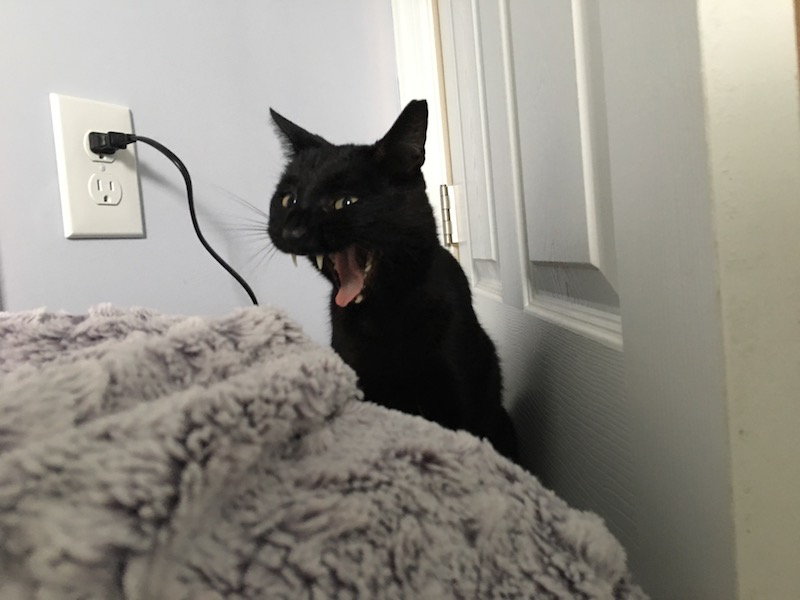

In [69]:
img = Image.open(path + fnames[1]); img

(my cat is a special character)

We need to subtract the mean of each channel of the imagenet data and reverse the order of RGB->BGR since those are the preprocessing steps that the VGG authors did - so their model won't work unless we do the same thing.

We can do this in one step using *broadcasting*, which is a topic we'll be returning to many times during this course.

In [71]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1] # this subtracts the reverse

In [72]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape

In [358]:
# img.size
# img_arr.shape
shp

(1, 309, 500, 3)

When we generate images from this network, we'll need to undo the above preprocessing in order to view them.

In [74]:
deproc = lambda x,s : np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)
# so this is adding back the mean to the un-reversed x after changing its dimension to 
# that of s via broadcasting, and normalizing(NumPy clipping) it into 256 colors?

#### Broadcasting Examples

In [75]:
np.array([1,2,3]) - 2

array([-1,  0,  1])

In [76]:
np.array([2,3]).reshape(1,1,1,2)

array([[[[2, 3]]]])

In [77]:
np.array([2,3]).reshape(1,1,2,1)

array([[[[2],
         [3]]]])

In [85]:
a = np.random.randn(5,1,9,2)
b = np.random.randn(2)
(a-b).shape

(5, 1, 9, 2)

### Recreate Input

The first step in style transfer is understanding how to recreate an image from noise based on "content loss", which is the amount of difference between activations in some layer. In earlier layers, content loss is very similar to per-pixel loss, but in later layers it is capturing the "meaning" of a part of an image, rather than the specific details.

To do this, we first take a CNN and pass an image through it. We then pass a "noise image" (ie: random pixel values) through the same CNN. At some layer, we compare the outputs from it for both images. We then use a MSE to compare the activations of these two outputs.

The interesting part is that now, instead of updating the parameters of the CNN, we update hte pixels of the noisy image. In other words, our goal is to alter the noisy image so as to minimize the difference between the original image's output at some convolutional layer with the output of the noisy image at the same layer.

In order to construct this architecture, we're going to be working with keras.backend, which is an abstraction layer that allows us to target both Theano and TensorFlow with the same code.

The CNN we'll use is VGG16, but with a twist << *ah right, from the paper!* >>. Previously we've alwyas used Vgg with Max Pooling, and this was useful for image classification. It's not as useful in this case however, because Max Pooling loses information about the original input area. Instead we'll use Average Pooling, as this doesn't throw away as much information.

In [90]:
model = VGG16_Avg(include_top=False)

Here we're grabbing the activations from near the end of the convolutional model.

In [96]:
layer = model.get_layer('block5_conv1').output

And let's calculate the target activations for this layer:

In [97]:
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

In our implementation, we need to define an object that'll allow us to separately access the loss function and gradients of a function, since that's what scikit-learn's optimizers require.

In [98]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
    
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    
    def grads(self, x): return self.grad_values.flatten().astype(np.float64)
    # oo lala float64, quite a bit of precision

We'll define our loss function to calculate the mean squared error between the two outputs at the specified convolutional layer.

In [99]:
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

Now we're going to optimize this loss function with a deterministic approach to optimization that uses a line search, which we can implement with sklearn's `fmin_1_bfgs_b` function.

In [148]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{path}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x
# ah, so yeah, x is un-reversed, then dim-broadcasted up to shape shp.
# f'...' assigns the string to f, where {..} specfs a variable as string

Next we need to generate a random image

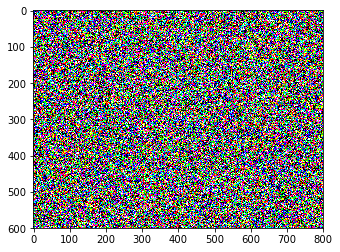

In [145]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)
plt.imshow(x[0]);

Now we'll run through this optimization approach ten times and train the noise image's pixels as desired.

In [146]:
iterations = 10

In [149]:
x = solve_image(evaluator, iterations, x)

Current loss value: 26.2889003754
Current loss value: 10.1755008698
Current loss value: 6.27227401733
Current loss value: 4.79265356064
Current loss value: 4.37177467346
Current loss value: 4.25606584549
Current loss value: 4.25581645966
Current loss value: 4.25581645966
Current loss value: 4.25581645966
Current loss value: 4.25581645966


In [150]:
# NOTE: iteration 0 above finished at 22:30.
# Loop (iter 9) finished: 
# aaand this is why GPUs are nicer.

# Iter 1: 22:36
# Iter 2: 22:42

Our result by comparing output at conv_1 of last block (5) is fairly amorphous, but still easily recognizable as the original image. Notice that the things it has reconstructed particularly well are those things that we expect Vgg16 to be good at recognizing; such as - in the case of a bird - an eye or beak.

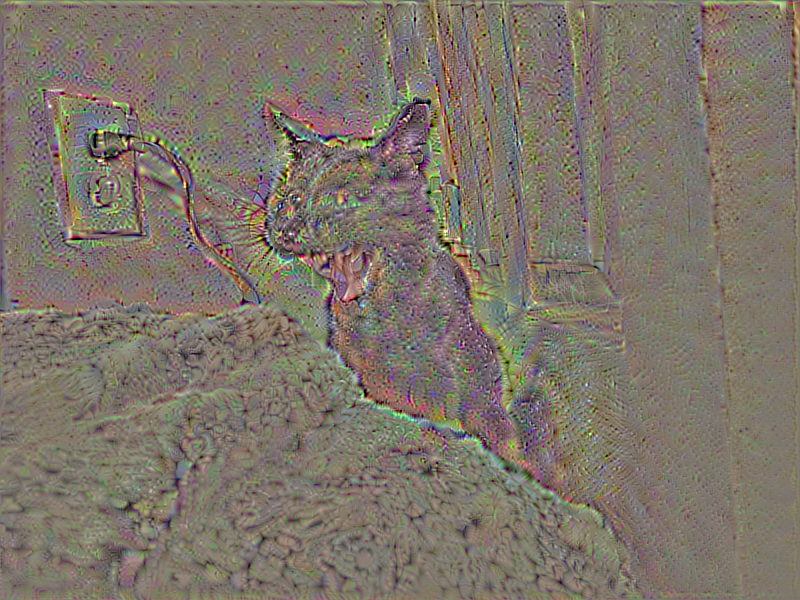

In [152]:
Image.open(path + 'results/res_at_iteration_9.png')

If instead we optimized by calculating loss from the output of conv 1 of the 4th block, our trained image looks much more like the original. This makes sense because with less transformations to go through, comparing at an earlier layer means that we have a smaller receptive field and the features are more based on geometric details rather than broad features.

In [166]:
# %mkdir neural-trsf-photos/results/block5
# %cd neural-trsf-photos/results
# %mv *.png block5/
# %cd ../..

block5/


Current loss value: 26.1967277527
Current loss value: 10.4800739288
Current loss value: 6.55256748199
Current loss value: 4.88062381744
Current loss value: 4.21343183517
Current loss value: 4.18185710907
Current loss value: 4.02310323715
Current loss value: 4.02291345596
Current loss value: 4.02291345596
Current loss value: 4.02291345596


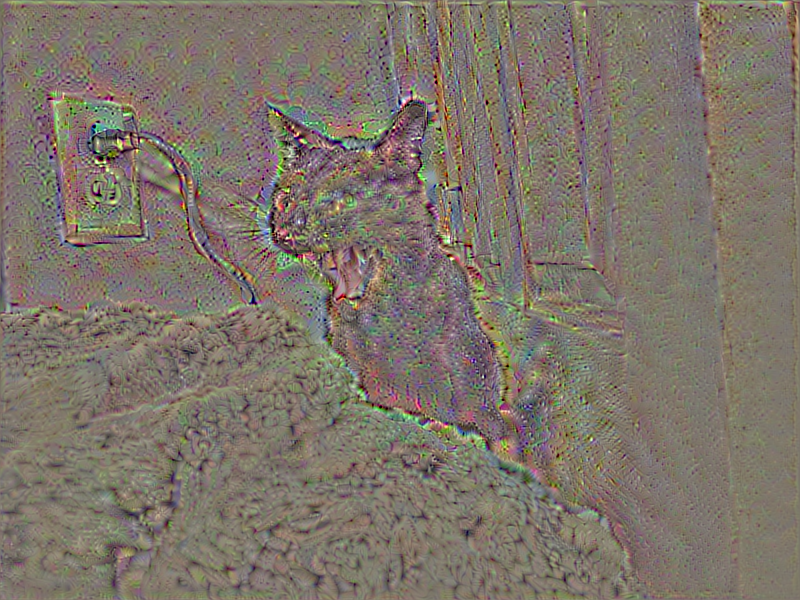

In [171]:
layer_blk4 = model.get_layer('block4_conv1').output
layer_blk4_model = Model(model.input, layer_blk4)
targ_blk4 = K.variable(layer_blk4_model.predict(img_arr))

loss_blk4 = metrics.mse(layer_blk4, targ_blk4)
grads_blk4 = K.gradients(loss_blk4, model.input)
fn_blk4 = K.function([model.input], [loss_blk4]+grads_blk4)
evaluator_blk4 = Evaluator(fn_blk4, shp)

y = rand_img(shp)
y = solve_image(evaluator, iterations, y)

Image.open(path + 'results/res_at_iteration_9.png')

In [172]:
from IPython.display import HTML
from matplotlib import animation, rc

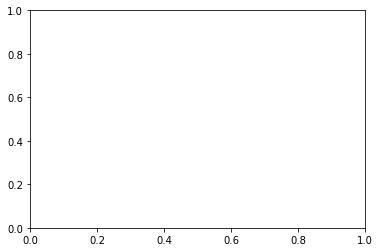

In [236]:
fig, ax = plt.subplots()
def animate(i): ax.imshow(Image.open(f'{path}results/res_at_iteration_{i}.png'))

The optimizer first focuses on the important details of the << cat >>, before trying to match the background.

In [241]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=300)
HTML(anim.to_html5_video())

#### Testing out Conv1 Block3 output:

In [243]:
%mkdir neural-trsf-photos/results/block4
%mv neural-trsf-photos/results/*.png neural-trsf-photos/results/block4/

In [248]:
# I don't quite understand why you'd get the output of the 1st layer in a block, 
# instead of the last layer in the preceeding block.
layer_blk3 = model.get_layer('block3_conv1').output
layer_blk3_model = Model(model.input, layer_blk3)
targ_blk3 = K.variable(layer_blk3_model.predict(img_arr))

loss_blk3 = metrics.mse(layer_blk3, targ_blk3)
grads_blk3 = K.gradients(loss_blk3, model.input)
fn_blk3 = K.function([model.input], [loss_blk3]+grads_blk3)
evaluator_blk3 = Evaluator(fn_blk3, shp)

z = rand_img(shp)
z = solve_image(evaluator, iterations, z)

Current loss value: 26.1839160919
Current loss value: 10.3736524582
Current loss value: 6.60899734497
Current loss value: 4.95577669144
Current loss value: 4.72541999817
Current loss value: 4.7137298584
Current loss value: 4.71380281448
Current loss value: 4.71380281448
Current loss value: 4.71380281448
Current loss value: 4.71380281448


### Recreate Style

Now that we've learned how to recreate an input image, we'll move onto attempting to recreate *style*. By 'style', we mean the color palette and texture of an image. Unlike recreating based on content, with style we're not concerned about the actual structure of what we're creating, all we care about is that it captures this concept of 'style'.

Here are some examples of images we can extract style from.

In [250]:
def plot_arr(arr): plt.imshow(deproc(arr, arr.shape)[0].astype('uint8'))

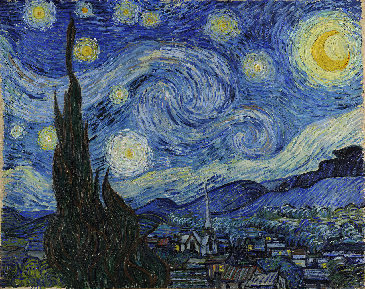

In [369]:
style = Image.open(dpath + 'starry-night.png')
style = style.resize(np.divide(style.size, 1.0).astype('int32')); style
# NOTE: can use the `1.0` to divide img size by any factor

In [370]:
style.size
# img_arr.shape

(365, 289)

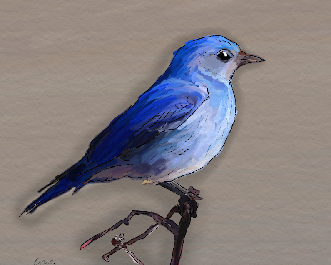

In [445]:
style = Image.open(dpath + 'bird.png')
style = style.resize(np.divide(style.size, 1.0).astype('int32')); style

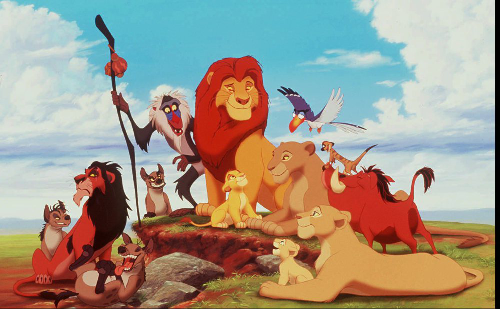

In [385]:
style = Image.open('data/lion-king.jpg')
style = style.resize(np.divide(style.size, 2.0).astype('int32')); style

We're going to repeat the same approach as before, but with some differences.

<< *doing this first for Van Gogh style above* >>

In [386]:
style_arr = preproc(np.expand_dims(style, 0)[:,:,:,:3])
shp = style_arr.shape

In [387]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {λ.name: λ.output for λ in model.layers}

One thing to ontice is that we're actually going to be calculating the loss function for multiple layers, rather than just one. (Note that there's no reason you couldn'y try using multiple layers in your content loss function, if you wanted to try that.)

In [307]:
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]

In [308]:
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]

The key difference is our choice of loss function. Whereas before we were calculating MSE of the raw convolutional outputs, here we transform them into the 'Gramian Matrix' of their channels (that is, the product of a matrix and its transpose) before taking their MSE. It's unclear why this helps us achieve our goal, but it works. One thought is that the Gramian shows how our features at that convolutional layer correlate, and completely removes all location information. So matching the Gram Matrix of channels can only match some type of texture information, not location information.

In [289]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [309]:
loss = sum(style_loss(λ1[0], λ2[0]) for λ1,λ2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(style_fn, shp)

We can solve as we did before.

In [291]:
import scipy

In [310]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/1
x = rand_img(shp)
x = scipy.ndimage.filters.gaussian_filter(x, [0,2,2,0])

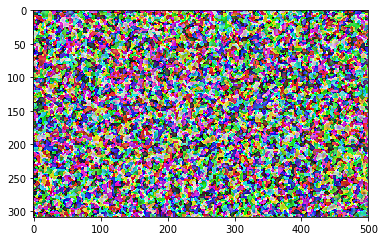

In [311]:
plt.imshow(x[0]);

**NOTE**: I was having an issue below with `content_targ = K.variable(content_model.predict(src))` throwing the error:

```
ValueError: Error when checking : expected input_8 to have shape (None, 309, 500, 3) but got array with shape (1, 289, 365, 3)
```

The reason was that when I re-set the style to be the VanGogh img, from the prevs Bird one, I didn't update style_arr to be the preprocessed style image. So two things: my preproc-style array was all wrong (dfnt img) anyway, but what was caught was that the dimensions of the VanGogh & Bird images were different.

Don't forget also the update the model to take in the new input shape.

In [312]:
iterations = 10
x = rand_img(shp)
# THOUGHT: maybe use a larger Van Gogh base image - would give computer more to work with?

In [296]:
x = solve_image(evaluator, iterations, x) # starry night

Current loss value: 5430.97265625
Current loss value: 203.713317871
Current loss value: 84.4739837646
Current loss value: 54.0193519592
Current loss value: 36.5002670288
Current loss value: 24.2852592468
Current loss value: 15.8954916
Current loss value: 10.2164611816
Current loss value: 6.81760597229
Current loss value: 5.27846717834


In [313]:
x = solve_image(evaluator, iterations, x) # redoing for lion king

Current loss value: 11267.4150391
Current loss value: 2334.23999023
Current loss value: 698.274658203
Current loss value: 225.90524292
Current loss value: 110.502159119
Current loss value: 53.7258148193
Current loss value: 32.6740951538
Current loss value: 20.961938858
Current loss value: 14.7477140427
Current loss value: 10.1764726639


Our results are stunning. By transforming the convolutional outputs to the Gramian, we're somehow able to update the noise pixels to produce an image that captures the raw style of the original image, with absolutely no structure of meaning.

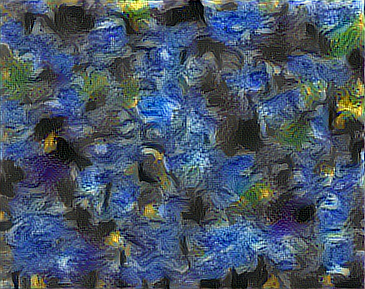

In [297]:
Image.open(path + 'results/res_at_iteration_9.png')

In [302]:
# %mkdir $path/results/VanGogh_rand
# %mv $path/results/*.png $path/results/VanGogh_rand/

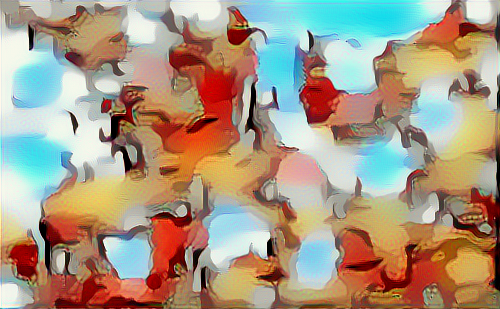

In [314]:
Image.open(path + 'results/res_at_iteration_9.png')

### Style Transfer

We now know how to reconstruct an image, as well as how to construct an image that captures the style of an original image. The obvious idea may be to just combine these two approaches by weighting and adding the two loss functions.

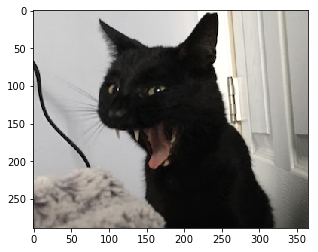

In [373]:
w,h = style.size
# src = img_arr[:,:h,:w]
src = img_arr[:,h//3:4*h//3,w//2:3*w//2] # getting the right view
plot_arr(src)

Like before, we're going to grab a sequence of layer outputs to compute the style loss. However, we still only need one layer output to compute the content loss. How do we know which layer to grab? As we discussed earlier, the lower the layer, the more exact the content reconstruction will be. In merging content reconstruction with style, we might expect that a looser reconstruction of the content will allow more room for the style to have an effect (re: inspiration). Furthermore, a later layer ensures that the image 'looks like' the same subject, even if it doesn't have the same details.

In [374]:
# as so this is why about the layer thing from before?
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1, 6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

In [375]:
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

In [376]:
content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))

Now to actually merge the two approaches is as simple as merging their respective loss functions. Note that as opposed to our previous functions, the function is producing three separate types of outputs: one for the original image, one for the image whose style we're emulating, and one for the random image whose pixel's we're training.

One way for us to tune how the reconstructions mix is by changing the factor on the content loss, which we have here as 1/10. If we icnrease that denominator, the style will have a larger effect on the image, and if it's too large the original content of the image will be obscured by unstructured style. Likewise, if it's too small then the image will not have enough style.

<< ***Always*** * gotta have enough style* >>

In [378]:
style_wgts = [0.05,0.2,0.2,0.25,0.3]

In [380]:
loss = sum(style_loss(λ1[0], λ2[0]) * w 
           for λ1, λ2, w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [381]:
evaluator = Evaluator(transfer_fn, shp)

In [382]:
iterations = 10
x = rand_img(shp)

In [383]:
x = solve_image(evaluator, iterations, x)

Current loss value: 2685.41894531
Current loss value: 831.553588867
Current loss value: 490.762420654
Current loss value: 399.963897705
Current loss value: 343.448516846
Current loss value: 305.788085938
Current loss value: 279.436462402
Current loss value: 262.868804932
Current loss value: 247.829940796
Current loss value: 234.237564087


These results are remarkable. Each does a fantastic job at recreating the original image in the style of the artist.

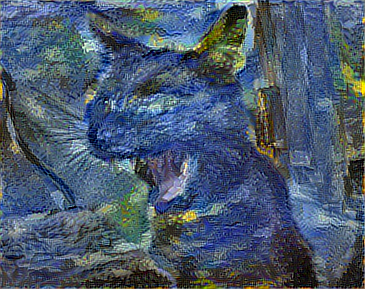

In [384]:
Image.open(path + 'results/res_at_iteration_9.png') # VanGogh style

In [394]:
# %mkdir $path/results/VanGogh_Terek
# %mv $path/results/*.png $path/results/VanGogh_Terek/

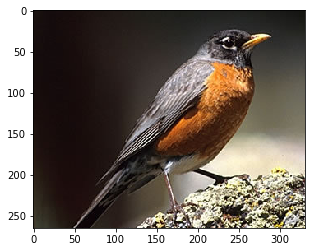

In [472]:
# style = Image.open(dpath + 'bird.png')
# style = style.resize(np.divide(style.size, 1.).astype('int32'))
# style.size

w,h = style.size

# img_arr = preproc(np.expand_dims(np.array(img), 0))


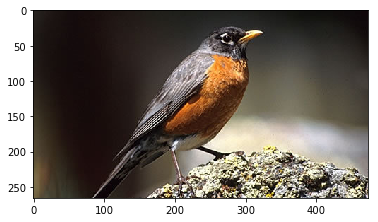

In [486]:
# Bird image
img = Image.open(path + fnames[5]); img

rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1] # this subtracts the reverse
img_arr = preproc(np.expand_dims(np.array(img), 0))

# <Select> Style:
style = Image.open(dpath + 'simpsons.png')
style = style.resize(np.divide(style.size, 1.0).astype('int32'))

style_arr = preproc(np.expand_dims(style, 0)[:,:,:,:3])
shp = style_arr.shape

model = VGG16_Avg(include_top=False, input_shape=shp[1:])
outputs = {λ.name: λ.output for λ in model.layers}

# #### ###
layers = [outputs['block{}_conv1'.format(o)] for o in range(1,3)]
layers_model = Model(model.input, layers)
targs = [K.variable(o) for o in layers_model.predict(style_arr)]
# #### ###

w,h = style.size
# src = img_arr[:,h//3:4*h//3,w//4:5*w//4]
# src = img_arr[:,h:2*h,3*w//2:5*w//2]
# src = img_arr[:,:h,w:2*w]
src = img_arr[:,:h,:w]
plot_arr(src)

# #### ###
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1, 6)]
content_name = 'block4_conv2'
content_layer = outputs[content_name]

style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]

content_model = Model(model.input, content_layer)
content_targ = K.variable(content_model.predict(src))
# #### ###

style_wgts = [0.05,0.2,0.2,0.25,0.3]

# #### ###
loss = sum(style_loss(λ1[0], λ2[0]) * w
           for λ1,λ2,w in zip(style_layers, style_targs, style_wgts))
loss += metrics.mse(content_layer, content_targ)/10
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)
# #### ###

evaluator = Evaluator(transfer_fn, shp)

In [490]:
src.size, style.size, img_arr.shape

(378252, (474, 266), (1, 291, 483, 3))

In [475]:
iterations=10
x = rand_img(shp)
x = solve_image(evaluator, iterations, x)

Current loss value: 917.760864258
Current loss value: 465.391662598
Current loss value: 330.242858887
Current loss value: 258.399810791
Current loss value: 216.155761719
Current loss value: 189.296264648
Current loss value: 172.321792603
Current loss value: 161.930358887
Current loss value: 154.745437622
Current loss value: 150.519363403


In [491]:
iterations=10
x = rand_img(shp)
x = solve_image(evaluator, iterations, x)

Current loss value: 8529.80859375
Current loss value: 1760.8067627
Current loss value: 936.110900879
Current loss value: 762.720703125
Current loss value: 654.709655762
Current loss value: 592.340515137
Current loss value: 551.457275391
Current loss value: 522.328125
Current loss value: 500.549957275
Current loss value: 483.105041504


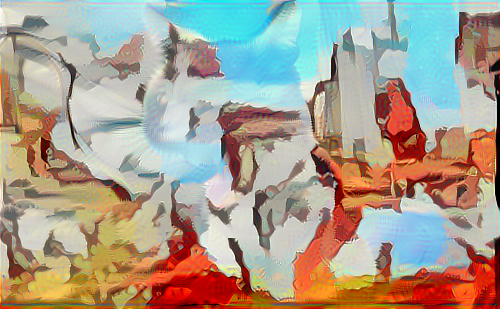

In [401]:
Image.open(path + 'results/res_at_iteration_9.png') # LionKing style

Oh dear God..

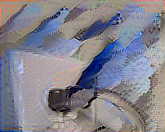

In [406]:
Image.open(path + 'results/res_at_iteration_9.png') # accidental powerplug

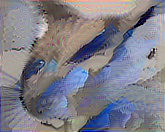

In [418]:
Image.open(path + 'results/res_at_iteration_9.png') # derVogel style

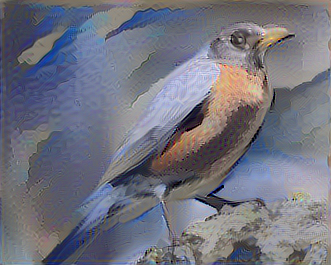

In [477]:
Image.open(path + 'results/res_at_iteration_9.png') # Vogel style

There are lots of interesting additional things you could try, such as the ideas shown here:
[https://github.com/titu1994/Neural-Style-Transfer](https//github.com/titu1994/Neural-Style-Transfer) .